## Exercise 06 : Scatter Matrix

* create a dataframe where each user of the test group has the average difference,
number of pageviews and number of commits
* do not take project1 into account for calculations of the average difference and the
number of commits
* take the number of commits from the checker table


In [ ]:
import pandas as pd 
import sqlite3
from pandas.plotting import scatter_matrix

con=sqlite3.connect("data/checking-logs.sqlite")
commit_query="""
SELECT 
    c.uid,
    COUNT(*) AS commits_num
FROM checker c 
    WHERE c.uid LIKE "user_%" AND c.labname!='project1'
GROUP BY c.uid
"""
page_query="""
SELECT
    p.uid,
    COUNT(*) AS page_views
FROM pageviews p
    WHERE p.uid LIKE "user_%"
GROUP BY p.uid
"""

avg_query="""
WITH first_commits AS (
    SELECT 
        c.uid,
        c.labname,
        MIN(c.timestamp) AS first_commit
    FROM checker c
    WHERE c.uid LIKE 'user_%' 
      AND c.labname != 'project1'
    GROUP BY c.uid, c.labname
)
SELECT 
    f.uid,
    AVG((strftime('%s', d.deadlines, 'unixepoch') - strftime('%s', f.first_commit)) / 3600.0) AS avg_diff_hours
FROM first_commits f
JOIN deadlines d ON f.labname = d.labs
GROUP BY f.uid
"""
df_commits=pd.read_sql(commit_query, con)
df_commits.head()

,uid,commits_num
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86


In [35]:
df_pageviews=pd.read_sql(page_query, con)
df_pageviews.head()

,uid,page_views
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3


In [36]:
df_avg=pd.read_sql(avg_query, con)
df_avg.head()

,uid,avg_diff_hours
0,user_1,65.119778
1,user_10,75.242444
2,user_11,2.884444
3,user_12,89.450764
4,user_13,48.878333


In [52]:
df_test=pd.read_csv('../data/ab-test.csv', sep=',')
df_test=df_test.drop(['diff', 'time'], axis=1)
df_test=df_test[df_test['group']=='test']
df_test


,uid,group
0,user_1,test
1,user_1,test
2,user_18,test
3,user_18,test
4,user_19,test
5,user_19,test
6,user_21,test
7,user_21,test
8,user_25,test
9,user_25,test


In [57]:
df_main= df_test[['uid']].copy()

df_main = df_main.merge(df_commits, on='uid', how='left')
df_main = df_main.merge(df_pageviews, on='uid', how='left')
df_main = df_main.merge(df_avg, on='uid', how='left')
df_main[['commits_num', 'page_views']] = df_main[['commits_num', 'page_views']].fillna(0)
df_main.drop_duplicates(subset=['uid'], inplace=True)
df_main=df_main.reset_index(drop=True)
df_main

,uid,commits_num,page_views,avg_diff_hours
0,user_1,62,28,65.119778
1,user_18,5,3,6.368148
2,user_19,118,16,99.440417
3,user_21,65,10,96.111181
4,user_25,79,179,93.474944
5,user_28,60,149,86.793833
6,user_3,18,317,105.738222


* the figsize is still the same, you can choose whatever fontsize you like as well as the
color palette
* the size of the dots should be 200
* the width of the lines of the diagonal graphs (kde) should be 3

array([[<Axes: xlabel='commits_num', ylabel='commits_num'>,
        <Axes: xlabel='page_views', ylabel='commits_num'>,
        <Axes: xlabel='avg_diff_hours', ylabel='commits_num'>],
       [<Axes: xlabel='commits_num', ylabel='page_views'>,
        <Axes: xlabel='page_views', ylabel='page_views'>,
        <Axes: xlabel='avg_diff_hours', ylabel='page_views'>],
       [<Axes: xlabel='commits_num', ylabel='avg_diff_hours'>,
        <Axes: xlabel='page_views', ylabel='avg_diff_hours'>,
        <Axes: xlabel='avg_diff_hours', ylabel='avg_diff_hours'>]],
      dtype=object)

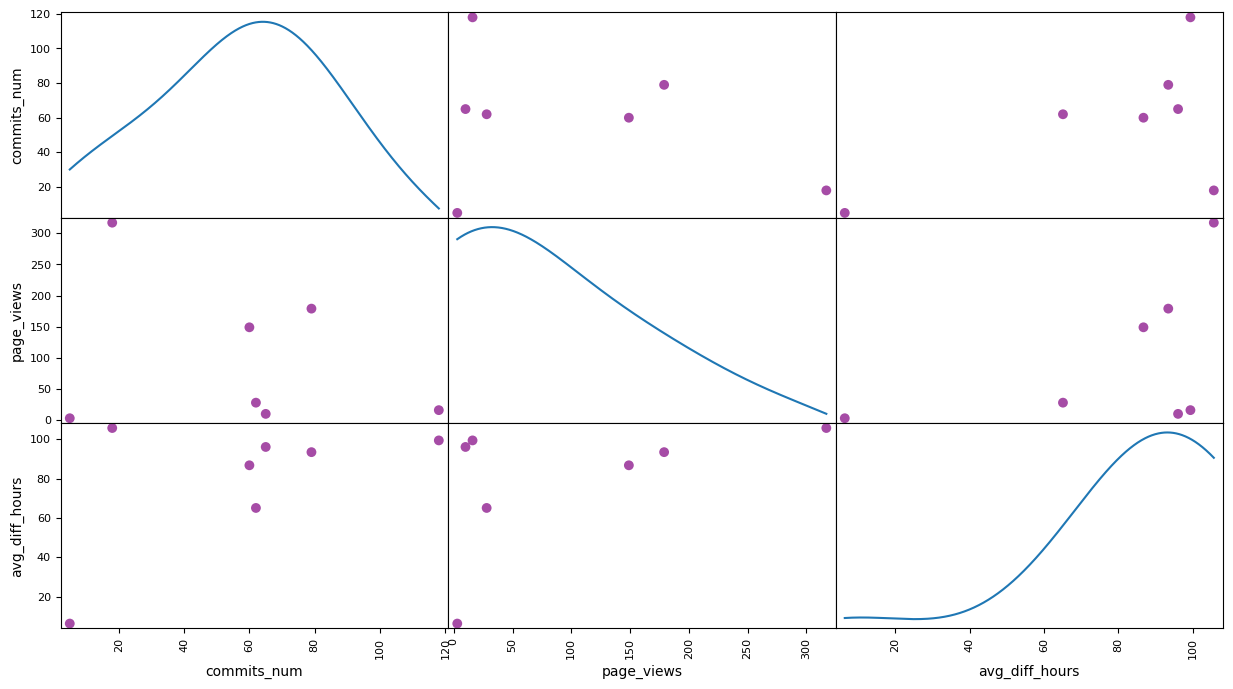

In [58]:
df_for_plot=df_main[['commits_num','page_views', 'avg_diff_hours']]
scatter_matrix(
    df_for_plot,
    figsize=(15,8),
    diagonal='kde',
    linewidth=3,
    s=200,
    color='purple',
    alpha=0.7
)

In [59]:
con.close()

* “Can we say that if a user has a low number of pageviews then they likely
have a low number of commits?” The answer: yes or no. 

NO

  * “Can we say that if a user has a low number of pageviews then they likely have
a small average difference between the first commit and the lab deadline?” The
answer: yes or no. 

NO

  * “Can we say that there are many users with a low number of commits and a
few with a high number of commits”? The answer: yes or no. 

YES

  * “Can we say that there are many users with a small average difference and a
few with a large average difference”? The answer: yes or no.

NO
